<a href="https://colab.research.google.com/github/icezyf/data_projects/blob/main/Youtube_Comments_Analysis_in_Apache_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Youtube Comments Analysis** #
**Write a Spark program to analyze the text data**

In this notebook, we have a dataset of user comments for youtube videos related to animals or pets. We will attempt to identify cat or dog owners based on these comments, find out the topics important to them, and then identify video creators with the most viewers that are cat or dog owners.

Analyzed by Crystella Yufei Zheng (11/07/2020)

**Content**

0. Packages Loading, Data ETL and Exploation
1. Data Preprocessing 
2. Modeling 
3. Model Application and Gaining Insights
4. Summary

## 0. Packages Loading, Data ETL and Exploation

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
# Miscellaneous operating system interfaces
import os 
# os.environ: A mapping object representing the string environment. 
# behaves like a python dictionary, so all the common dictionary operations like get 
# and set can be performed. 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [3]:
import findspark
# Provides findspark.init() to make pyspark importable as a regular library.
findspark.init() 
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
spark.version

'3.1.2'

In [5]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# https://drive.google.com/file/d/1o3DsS3jN_t2Mw3TsV0i7ySRmh9kyYi1a/view?usp=sharing
file = drive.CreateFile({'id':'1o3DsS3jN_t2Mw3TsV0i7ySRmh9kyYi1a'}) 
file.GetContentFile('animals_comments.csv.gz')

In [7]:
# unzip the .gz file
!gunzip animals_comments.csv.gz

In [8]:
!ls

adc.json	      sample_data		 spark-3.1.2-bin-hadoop3.2.tgz
animals_comments.csv  spark-3.1.2-bin-hadoop3.2


In [9]:
df = spark.read.load('/content/animals_comments.csv', format='csv', header=True)
df.show(10)

+--------------------+------+-------------------------------------+
|        creator_name|userid|                              comment|
+--------------------+------+-------------------------------------+
|        Doug The Pug|    87|                 I shared this to ...|
|        Doug The Pug|    87|                   Super cute  😀🐕🐶|
|         bulletproof|   530|                 stop saying get e...|
|       Meu Zoológico|   670|                 Tenho uma jiboia ...|
|              ojatro|  1031|                 I wanna see what ...|
|     Tingle Triggers|  1212|                 Well shit now Im ...|
|Hope For Paws - O...|  1806|                 when I saw the en...|
|Hope For Paws - O...|  2036|                 Holy crap. That i...|
|          Life Story|  2637|武器はクエストで貰えるんじゃないん...|
|       Brian Barczyk|  2698|                 Call the teddy Larry|
+--------------------+------+-------------------------------------+
only showing top 10 rows



In [10]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
 
os.environ["PYSPARK_PYTHON"] = "python3"

In [11]:
df_size = df.count()
unique_user = df.select('userid').distinct().count()
print(f'''
The size of the data is {df.count()} with total {unique_user} users. 
''')


The size of the data is 5820035 with total 2537174 users. 



In [12]:
# Count None, NULL & Empty String Literal Values
from pyspark.sql.functions import col,isnan,when,count
df.select([count(when(col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                        for c in df.columns]).show()

+------------+------+-------+
|creator_name|userid|comment|
+------------+------+-------+
|       32050|   565|   1060|
+------------+------+-------+



In [13]:
# As we can see the dataframe contains a lot of null or missing values, we need to drop them all.
df = df.dropna()
df.count()

5786944

In the comment column, all words related to cat or dog need to be picked out and labeled for later use.

*   To verify if the users have preference of dog or cat
*   To analyze everything regarding dog and cat
*   To identify whether the comment creators are the owners of dog or cat





In [14]:
from pyspark.sql.functions import when, col

df = df.withColumn('label',\
                   (when(col('comment').like('%my dog$'), 1)\
                    .when(col('comment').like('%my cat%'), 1)\
                    .when(col('comment').like('%I have a dog%'), 1)\
                    .when(col('comment').like('%I have a cat%'), 1)\
                    .when(col('comment').like('%cat that I have%'), 1)\
                    .when(col('comment').like('%dog that I have%'), 1)\
                    .when(col('comment').like('%my puppy%'), 1)\
                    .when(col('comment').like('%my pup%'), 1)\
                    .when(col('comment').like('%my kitty%'), 1)\
                    .when(col('comment').like('%my pussy%'), 1)\
                    .when(col('comment').like('%my doggy%'), 1)\
                    .when(col('comment').like('%my kitten%'), 1)\
                    .when(col('comment').like('%I adopted a dog%'), 1)\
                    .when(col('comment').like('%I adopted a cat%'), 1)\
                    .otherwise(0)))
df.registerTempTable('comment_view')
df.show(5)

+-------------+------+--------------------+-----+
| creator_name|userid|             comment|label|
+-------------+------+--------------------+-----+
| Doug The Pug|    87|I shared this to ...|    0|
| Doug The Pug|    87|  Super cute  😀🐕🐶|    0|
|  bulletproof|   530|stop saying get e...|    0|
|Meu Zoológico|   670|Tenho uma jiboia ...|    0|
|       ojatro|  1031|I wanna see what ...|    0|
+-------------+------+--------------------+-----+
only showing top 5 rows



In [15]:
df_pet = df.filter(col('label')==1)
owner_id = df_pet.select('userid').distinct()
print(f'At the current step, we assume there are {owner_id.count()} owners of cat or dog.')
owner_id.toPandas().head()

At the current step, we assume there are 17606 owners of cat or dog.


,userid
0,812785
1,1581040
2,2173360
3,1004717
4,352569


## 1. Data Preprocessing

In [16]:
from pyspark.ml.feature import RegexTokenizer, Word2Vec
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# RegexTokenizer allows more advanced tokenization based on regular expression (regex) matching.
# Word2Vec is an Estimator which takes sequences of words representing documents and trains a Word2VecModel. 
# The model maps each word to a unique fixed-size vector. The Word2VecModel transforms each document into a vector 
# using the average of all words in the document; this vector can then be used as features for prediction, 
# document similarity calculations, etc. 

regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="words", pattern="\\W")
word2vec = Word2Vec(inputCol='words', outputCol='features')
pipeline = Pipeline(stages=[regexTokenizer, word2vec])

In [17]:
df_pipeline = pipeline.fit(df)
dataset = df_pipeline.transform(df)
dataset.show(5)

+-------------+------+--------------------+-----+--------------------+--------------------+
| creator_name|userid|             comment|label|               words|            features|
+-------------+------+--------------------+-----+--------------------+--------------------+
| Doug The Pug|    87|I shared this to ...|    0|[i, shared, this,...|[0.07503372532400...|
| Doug The Pug|    87|  Super cute  😀🐕🐶|    0|       [super, cute]|[0.28366623818874...|
|  bulletproof|   530|stop saying get e...|    0|[stop, saying, ge...|[0.05312312208116...|
|Meu Zoológico|   670|Tenho uma jiboia ...|    0|[tenho, uma, jibo...|[0.18793341874455...|
|       ojatro|  1031|I wanna see what ...|    0|[i, wanna, see, w...|[0.07654312185265...|
+-------------+------+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



Because the label of the dataset contains 0 and 1. In order not to split data into homogeneous subsets, here we are going to apply Stratified Sampling method so that a sampling consisting of these subsets is execuated according to the percentages given in the parameters.

In [18]:
dataset.groupBy('label').count().orderBy('count').show()

+-----+-------+
|label|  count|
+-----+-------+
|    1|  20052|
|    0|5766892|
+-----+-------+



In [19]:
# split dataset with label = 1 into training and test datasets
train_1, test_1 = dataset.filter(col('label')==1).randomSplit([0.7, 0.3], seed = 100)

# split dataset with label = 0 into training dataset
train_0, label_ex = dataset.filter(col('label')==0).randomSplit([0.005, 0.995], seed = 100)
# split the 99.5% dataset with label = 1 again into test dataset
test_0, label_ex1 = label_ex.randomSplit([0.002, 0.998], seed = 100)

In [20]:
df_train = train_0.union(train_1) # 0.8 (label=0) union 0.005 (label=1)
df_test = test_0.union(test_1) # 0.2 (label=0) union 0.00199 (label=1)

In [21]:
df_train.toPandas().head()

,creator_name,userid,comment,label,words,features
0,#CameraLord™ • Kor Capital,368152,https://youtu.be/byw247Bp3Wg bos,0,"[https, youtu, be, byw247bp3wg, bos]","[0.5637779831886292, 0.08340241461992265, -0.0..."
1,100% Madison,138327,cute(°▽°)！,0,[cute],"[0.15399721264839172, -0.2082165628671646, 0.0..."
2,1013,1917348,The fkn bro,0,"[the, fkn, bro]","[0.13335698346296945, 0.0802024354537328, -0.1..."
3,101rabbits,1271013,Omg I LOVE your vids you take such good care o...,0,"[omg, i, love, your, vids, you, take, such, go...","[-0.11075327585318258, -0.02640073786356619, 0..."
4,101rabbits,1695251,Hi your vids help so much! Thx Ive got two bunnys,0,"[hi, your, vids, help, so, much, thx, ive, got...","[0.0485401466827501, -0.018559655851938507, 0...."


In [22]:
print(f'''
Training Dataset Labeled 1 Count: {train_1.count()}
Training Dataset Labeled 0 Count: {train_0.count()}
The Ratio in Training Dataset is: {round(train_1.count()/train_0.count()*100, 2)}
Test Dataset Labeled 1 Count: {test_1.count()}
Test Dataset Labeled 0 Count: {test_0.count()}
The Ratio in Test Dataset is: {round(test_1.count()/test_0.count()*100, 2)}
Training Dataset Count: {df_train.count()}
Test Dataset Count: {df_test.count()}
''')


Training Dataset Labeled 1 Count: 13989
Training Dataset Labeled 0 Count: 28737
The Ratio in Training Dataset is: 48.68
Test Dataset Labeled 1 Count: 6063
Test Dataset Labeled 0 Count: 11506
The Ratio in Test Dataset is: 52.69
Training Dataset Count: 42726
Test Dataset Count: 17569



## 2. Modeling  
There will be three models applied on:


*   Logistic Regression 
*   Random Forests
*   Gradient Boosting Trees

The best performance one will be selected.

###2.1 Logistic Regression for Binary Classification

In [23]:
from pyspark.ml.classification import LogisticRegression

# create the multinomial family for binary classification
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family='binomial')

# train model with training dataset
lrModel = lr.fit(df_train)

In [24]:
predictions_lr = lrModel.transform(df_test)
predictions_lr.toPandas().head()

,creator_name,userid,comment,label,words,features,rawPrediction,probability,prediction
0,#CameraLord™ • Kor Capital,368152,https://youtu.be/byw247Bp3Wg bos,0,"[https, youtu, be, byw247bp3wg, bos]","[0.5637779831886292, 0.08340241461992265, -0.0...","[0.7199141845745709, -0.7199141845745709]","[0.6725881196461171, 0.3274118803538829]",0.0
1,1013,1996162,2:33 shoutout :*,0,"[2, 33, shoutout]","[0.13424982627232868, -0.2499800125757853, -0....","[0.7199141845745709, -0.7199141845745709]","[0.6725881196461171, 0.3274118803538829]",0.0
2,101rabbits,1282495,Would love it if you could make longer vids li...,0,"[would, love, it, if, you, could, make, longer...","[0.03143175390477364, -0.00445102140880548, -0...","[0.7199141845745709, -0.7199141845745709]","[0.6725881196461171, 0.3274118803538829]",0.0
3,101rabbits,1713410,Where did you find those boxes with vegetable ...,0,"[where, did, you, find, those, boxes, with, ve...","[0.11158693923304477, -0.041031891480088234, -...","[0.7199141845745709, -0.7199141845745709]","[0.6725881196461171, 0.3274118803538829]",0.0
4,125 076 758 просмотров,1154433,ВЕСТА КРОСС КРАСАВИЦА :),0,[],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7199141845745709, -0.7199141845745709]","[0.6725881196461171, 0.3274118803538829]",0.0


In [25]:
trainingSummary_lr = lrModel.summary
print("area Under ROC: " + str(trainingSummary_lr.areaUnderROC))
print("fMeasure: " + str(trainingSummary_lr.weightedFMeasure()))
print("Accuracy: " + str(trainingSummary_lr.accuracy))

area Under ROC: 0.5
fMeasure: 0.54092788699804
Accuracy: 0.6725881196461171


In [26]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder()\
            .addGrid(lrModel.regParam, [0.01, 0.5, 1.0])\
            .addGrid(lrModel.elasticNetParam, [0.1, 0.5])\
            .addGrid(lrModel.maxIter, [1, 5, 10])\
            .build()

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# create 5-fold Cross Validation
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# run cross validation
cvModel_lr = cv_lr.fit(df_train)

In [28]:
# Take the best model of Losgitic Regression
cvBestModel_lr = cvModel_lr.bestModel
predictions_cv_lr = cvBestModel_lr.transform(df_test)
lrEval = BinaryClassificationEvaluator().evaluate(predictions_cv_lr)
print("Area Under ROC: {:.4f}".format(lrEval))

Area Under ROC: 0.9452


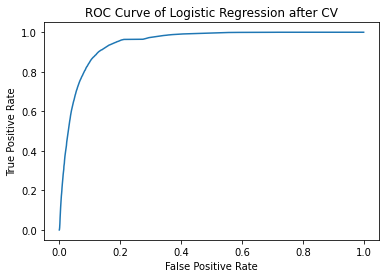

In [29]:
trainingSummary_cv1 = cvBestModel_lr.summary
roc_cv1 = trainingSummary_cv1.roc.toPandas()
plt.plot(roc_cv1['FPR'],roc_cv1['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression after CV')
plt.show()

###2.2 Random Forests

In [30]:
from pyspark.ml.classification import RandomForestClassifier

# create an initial Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20)
# train model with training dataset
rfModel = rf.fit(df_train)
# make predictions on test dataset using the transform() method
predictions_rf = rfModel.transform(df_test)

In [31]:
predictions_rf.toPandas()[['probability', 'prediction', 'label']][:5]

,probability,prediction,label
0,"[0.8585110618162716, 0.14148893818372837]",0.0,0
1,"[0.7589797715749764, 0.24102022842502352]",0.0,0
2,"[0.8652577417546693, 0.13474225824533065]",0.0,0
3,"[0.8856599742258062, 0.11434002577419378]",0.0,0
4,"[0.9002171810740982, 0.0997828189259017]",0.0,0


In [32]:
evaluator = BinaryClassificationEvaluator(labelCol='label')

rf_roc = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC: {:.4f}".format(rf_roc))

Area under ROC: 0.9500


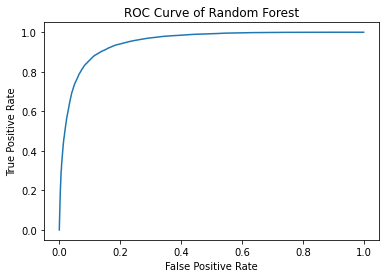

In [33]:
trainingSummary_rf = rfModel.summary
roc_rf = trainingSummary_rf.roc.toPandas()
plt.plot(roc_rf['FPR'],roc_rf['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.show()

###2.3 Gradient Boosting Tree Model 
Gradient-Boosted Trees (GBTs) learning algorithm for classification. It supports binary labels, as well as both continuous and categorical features.



In [34]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer

In [35]:
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10)
gbtModel = gbt.fit(df_train)
predictions_gbt = gbtModel.transform(df_test)

In [36]:
evaluator_gbt = BinaryClassificationEvaluator(labelCol='label')
gbt_roc = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC: {:.4f}".format(gbt_roc))

Area under ROC: 0.9465


In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")
    
gbt_accurancy = binEval.evaluate(predictions_gbt)

In [38]:
# create ParamGrid for Cross Validation
paramGrid_gbt = ParamGridBuilder()\
            .addGrid(gbtModel.maxDepth, [2, 4, 6])\
            .addGrid(gbtModel.maxBins, [20, 30])\
            .addGrid(gbtModel.maxIter, [1, 5, 10])\
            .build()

In [39]:
# create 5-fold Cross Validation
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid_gbt, evaluator=BinaryClassificationEvaluator(), numFolds=5)

# run cross validation
cvModel_gbt = cv_gbt.fit(df_train)
cvBestModel_gbt = cvModel_gbt.bestModel
predictions_cv_gbt = cvBestModel_gbt.transform(df_test)

In [40]:
gbtEval = BinaryClassificationEvaluator().evaluate(predictions_cv_gbt)
print("Area Under ROC: {:.4f}".format(gbtEval))

Area Under ROC: 0.9526


###Get the best model
**Logistic Regression:**
> Area under ROC: 0.5   
*After 5-fold cross validation:*   
Area under ROC after CV: 0.9452 

**Random Forests:** 
> Area under ROC: 0.9500  
(I did not apply cross validation method for Random Forests because out-of-bag performance for a random forest is very similar to cross validation.)

**Gradient Boosting Tree:**. 
> Area under ROC: 0.9465   
*After 5-fold cross validation:*   
Area under ROC after CV: 0.9526
   
  

#3. Model Application and Gaining Insights

###3.1 Classifier All Users with Best Model - Gradient Boosting Tree

In [41]:
alldata = cvBestModel_gbt.transform(dataset)
gbtEval_all = evaluator_gbt.evaluate(alldata)
print("Area under ROC for the whole dataset: {:.4f}".format(gbtEval_all))

Area under ROC for the whole dataset: 0.9541


**Important Note:**

I was supposed to apply the best model on the whhole dataset. Due to the significant oversubscribed memory of free Google Colab for this big data (5,820,035), I'm going to choose the predicitons dataset of Gradient - Boosting - Model  for the following practices.

In [42]:
predictions_cv_gbt.toPandas().head(10)

,creator_name,userid,comment,label,words,features,rawPrediction,probability,prediction
0,#CameraLord™ • Kor Capital,368152,https://youtu.be/byw247Bp3Wg bos,0,"[https, youtu, be, byw247bp3wg, bos]","[0.5637779831886292, 0.08340241461992265, -0.0...","[1.2448042534910029, -1.2448042534910029]","[0.9234101193357447, 0.07658988066425532]",0.0
1,1013,1996162,2:33 shoutout :*,0,"[2, 33, shoutout]","[0.13424982627232868, -0.2499800125757853, -0....","[1.381827438370501, -1.381827438370501]","[0.940679909380121, 0.059320090619878973]",0.0
2,101rabbits,1282495,Would love it if you could make longer vids li...,0,"[would, love, it, if, you, could, make, longer...","[0.03143175390477364, -0.00445102140880548, -0...","[1.2207258035780135, -1.2207258035780135]","[0.9199340716936077, 0.08006592830639225]",0.0
3,101rabbits,1713410,Where did you find those boxes with vegetable ...,0,"[where, did, you, find, those, boxes, with, ve...","[0.11158693923304477, -0.041031891480088234, -...","[0.8183834506809807, -0.8183834506809807]","[0.8370945289238596, 0.1629054710761404]",0.0
4,125 076 758 просмотров,1154433,ВЕСТА КРОСС КРАСАВИЦА :),0,[],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3316604249103967, -1.3316604249103967]","[0.9348272825185209, 0.06517271748147913]",0.0
5,125 076 758 просмотров,1330308,Крутой,0,[],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3316604249103967, -1.3316604249103967]","[0.9348272825185209, 0.06517271748147913]",0.0
6,2CAN.TV - Ripley the Toucan!,144752,I think youre banana has autism,0,"[i, think, youre, banana, has, autism]","[-0.019910216952363648, -0.061144583548108734,...","[0.8576684200946078, -0.8576684200946078]","[0.8475272163518424, 0.15247278364815764]",0.0
7,2CAN.TV - Ripley the Toucan!,2401745,Thats a very unusual dog.,0,"[thats, a, very, unusual, dog]","[0.07750902771949769, 0.10839851498603821, 0.0...","[1.1490396529190439, -1.1490396529190439]","[0.9087178429542137, 0.09128215704578635]",0.0
8,2CAN.TV - Ripley the Toucan!,2468925,This toucan’s noises make it so punchable.,0,"[this, toucan, s, noises, make, it, so, puncha...","[0.0470953278709203, 0.03533136332407594, 0.08...","[0.8662934870345197, -0.8662934870345197]","[0.8497430235686878, 0.1502569764313122]",0.0
9,2CAN.TV - Ripley the Toucan!,556925,Looks like me when theres nothing to eat in th...,0,"[looks, like, me, when, theres, nothing, to, e...","[0.06863511918874628, 0.08040078333579004, -0....","[1.2208404757056426, -1.2208404757056426]","[0.9199509625040125, 0.08004903749598746]",0.0


**Fractions of the users who owns cats or dogs:**

> fraction_prediction = num of owner predicted / total users   
> fraction_label = num of owner labeled / total users

In [45]:
# Predict the number of pet owners
import pyspark.sql.functions as F
owner_pred_cnt = predictions_cv_gbt.filter(F.col('prediction') == 1.0).count()
 
# Count the number of labeled owners
owners_label_cnt = predictions_cv_gbt.filter(F.col('label') == 1).count()
 
# Count number of total users
total_users_cnt = predictions_cv_gbt.select('userid').distinct().count()
 
# Estimate the fraction of all users who are cat/dog owners.
fraction_pred = owner_pred_cnt / total_users_cnt
fraction_label = owners_label_cnt / total_users_cnt
print("Fraction of the predicted pet owner is", round(fraction_pred, 3))
print("Fraction of the labeled pet owner is", round(fraction_label, 3))

Fraction of the predicted pet owner is 0.357
Fraction of the labeled pet owner is 0.358


###3.2 Get Insights of Users

**Remove Stop Words**

In [69]:
from pyspark.ml.feature import StopWordsRemover
 
# add some words to stop words
stopwordList = ['one', 'im', 'dont', 'really', 'time', 'got', 'much']
stopwordList.extend(StopWordsRemover().getStopWords())

# remove stop words
remover = StopWordsRemover(inputCol="words", outputCol='filtered_words', stopWords=stopwordList)
filtered_words_df = remover.transform(predictions_cv_gbt).select('filtered_words').dropna()

 
# Display
filtered_words_df.printSchema()
filtered_words_df.toPandas().head(10)

root
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)



,filtered_words
0,"[https, youtu, byw247bp3wg, bos]"
1,"[2, 33, shoutout]"
2,"[love, make, longer, vids, like, agree]"
3,"[find, boxes, vegetable, die, sounds, awesome]"
4,[]
5,[]
6,"[think, youre, banana, autism]"
7,"[thats, unusual, dog]"
8,"[toucan, noises, make, punchable]"
9,"[looks, like, theres, nothing, eat, kitchen]"


**Look at the reasons from the text**

In [70]:
from pyspark.sql.functions import explode
 
wordsDF = (filtered_words_df
                    .select(explode(filtered_words_df.filtered_words).alias('word')))
words_count = wordsDF.groupby('word').count().orderBy('count', ascending = False)
words_count.show()

+------+-----+
|  word|count|
+------+-----+
|   cat| 5147|
|  like| 3027|
|  love| 2114|
|  cats| 1902|
|   get| 1334|
|   dog| 1322|
| video| 1025|
|  know|  874|
| looks|  785|
|  good|  746|
|  cute|  724|
|   see|  720|
| puppy|  683|
|videos|  656|
|  want|  651|
|   lol|  637|
| think|  600|
|people|  576|
|    go|  573|
|kitten|  571|
+------+-----+
only showing top 20 rows



###3.4 Identify Creators with Cat or Dog Owners in the Audience

In [52]:
# find the creators who are the cat/dog owners
owner_creator_df = predictions_cv_gbt.filter(F.col('prediction') == 1.0).select('creator_name')

# find the count of comments from those cat/dog owners
owner_cnt = owner_creator_df.groupby('creator_name').count().orderBy('count', ascending=False)
owner_cnt.show()

+--------------------+-----+
|        creator_name|count|
+--------------------+-----+
|    Cole & Marmalade|  764|
|        Robin Seplut|  491|
|            The Dodo|  362|
|  Taylor Nicole Dean|  277|
|   Talking Kitty Cat|  274|
|           meow meow|  237|
|           Vet Ranch|  214|
|    Brave Wilderness|  188|
|Zak Georges Dog T...|  186|
|          stacyvlogs|  184|
|       Brian Barczyk|  175|
|Hope For Paws - O...|  150|
|       Cat Man Chris|  138|
|     Gohan The Husky|  118|
|      Kitten Academy|   99|
|          MaxluvsMya|   95|
|Gone to the Snow ...|   95|
|             Steff J|   87|
|          Funny Pets|   85|
|     Viktor Larkhill|   77|
+--------------------+-----+
only showing top 20 rows



In [57]:
total_num = owner_creator_df.select('creator_name').distinct().count()
print("The total number pet ownders is: " + str(total_num))

The total number pet ownders is: 375


In [58]:
top_owner = owner_cnt.limit(1)
top_owner.show()

+----------------+-----+
|    creator_name|count|
+----------------+-----+
|Cole & Marmalade|  764|
+----------------+-----+



In [68]:
all_creator = predictions_cv_gbt.select('creator_name')
total_creator_num = all_creator.agg(F.sum('creator_name')).collect()[0][0]
print('The ratio of top creator is {:.4f}'.format(764/total_creator_num))

The ratio of top creator is 0.3771


#4. Summary

**4.1 Project Overview**  
This dataset was built up on the configuration for cat and/or dog owners with 3 columns -- creator_name, userid and comments, of which total comments were 5,820,035 pieces. The orignial dataset was unlabeled.

**4.2 Data Cleaning and Modeling**  
After dropping all null values, special words from comments related to dog and cat have been labeled as "0 or 1" by applying RegexTokenizer and Word2Vec. Logistic Regression, Random Forests and Gradient Boosting Trees models have been applied on the training dataset. Evevtually, Gradient Boosting Trees model has been selected with resepect to the best score of "Area under ROC".  

**4.3 Model Application and Finding Insights**  
The whole predicted dataset is supposed to be taken on analytics. Due to the significant oversubscribed memory of free Google Colab, the predicted test dataset is taken as substitude to obtain statistical insights of those dog/cat owners.

**4.4 Data Analysis**  
To identify if words matter is for users, pet ownders or creators, I extracted words from comments by using StopWordRemover to remove those meaningfulless words and count the frequencies of them. Then it has been found out they conveyed in a positive, sympathy and warmhearted way, such as "like", "love", "good", "cute" and etc.

**4.5 Recommendation based on the Model Result**  
Based on such a completed model, it could be applied for unsupervised machine learning like comments, text or documents on any websites with no limit to animal topics, video streaming and etc.

